In [1]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [2]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [3]:
len(train_dataset), len(test_dataset)

(60000, 10000)

In [4]:
train_dataset[0][0].shape, test_dataset[0][1]

(torch.Size([1, 28, 28]), 7)

In [5]:
train_dataset[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

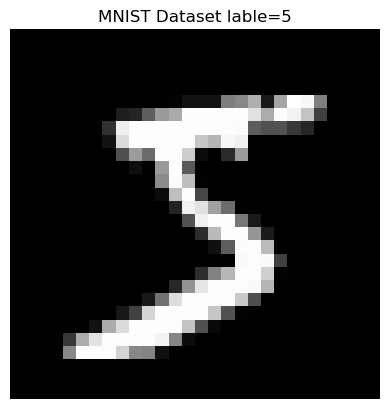

In [18]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(train_dataset[0][0].numpy().reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.title(f'MNIST Dataset lable={train_dataset[0][1]}')
plt.axis('off')
plt.show()

In [73]:
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

# x_train = np.load('./mnist/x_train.npy')
# y_train = np.load('./mnist/y_train_label.npy')
# print(x_train.shape)

class Unet(torch.nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        # 模块化结构，这也是后面常用到的模型结构
        self.first_block_down = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), torch.nn.GELU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.second_block_down = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), torch.nn.GELU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.latent_space_block = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), torch.nn.GELU(),
        )

        self.second_block_up = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1), torch.nn.GELU(),
        )

        self.first_block_up = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1), torch.nn.GELU(),
        )

        # self.convUP_end = torch.nn.Sequential(
        #     torch.nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, padding=1),
        #     torch.nn.Tanh()
        # )
        # 最后的特征整合（不再输出图像，而是分类向量）
        self.global_pool = nn.AdaptiveAvgPool2d(1)  # 输出 [B, 32, 1, 1]
        self.fc = nn.Linear(32, 10)        # 分类层

    def forward(self,img_tensor):
        image = img_tensor
        image = self.first_block_down(image)
        image = self.second_block_down(image)
        image = self.latent_space_block(image)

        image = self.second_block_up(image)
        image = self.first_block_up(image)

        # image = self.convUP_end(image)
        # Global Pool + FC 分类
        pooled = self.global_pool(image)            # [B, 32, 1, 1]
        flattened = pooled.view(pooled.size(0), -1) # [B, 32]
        logits = self.fc(flattened)                 # [B, num_classes]
        return logits


from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

unet = Unet()
device = torch.device('mps')
unet.to(device)
unet = torch.compile(unet)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(unet.parameters(), lr=0.001)
for epoch in range(20):
    running_loss = 0.0
    for data in tqdm(train_loader, desc='Training epoch {}'.format(epoch+1)):
        batch = len(data)
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = unet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    writer.add_scalar('loss', running_loss, epoch)
    print('[%d] loss: %.3f' % (epoch + 1, running_loss))


writer.close()

Training epoch 1:  99%|█████████▉| 933/938 [00:07<00:00, 127.44it/s]/opt/miniconda3/envs/homl3/lib/python3.10/site-packages/torch/autograd/graph.py:829: UserWarning: Error detected in MaxPool2DBackward0. Traceback of forward call that caused the error:
  File "/var/folders/kw/ysl7ggsn6wz6r9ms_r7scdgh0000gn/T/ipykernel_5795/3685460515.py", line 49, in forward
    image = self.second_block_down(image)
 (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/python_anomaly_mode.cpp:127.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
W1023 09:14:11.641000 5795 site-packages/torch/_dynamo/exc.py:525] [23/1] Backend compiler exception
W1023 09:14:11.641000 5795 site-packages/torch/_dynamo/exc.py:525] [23/1]   Explanation: Backend compiler `inductor` failed with aten.max_pool2d_backward.default. Adding a graph break.
W1023 09:14:11.641000 5795 site-packages/torch/_dynamo/exc.py:525] [23/1]   Hint: Report

[1] loss: 499.538


Training epoch 2: 100%|██████████| 938/938 [00:06<00:00, 136.64it/s]


[2] loss: 121.714


Training epoch 3: 100%|██████████| 938/938 [00:06<00:00, 137.07it/s]


[3] loss: 75.392


Training epoch 4: 100%|██████████| 938/938 [00:06<00:00, 136.18it/s]


[4] loss: 57.534


Training epoch 5: 100%|██████████| 938/938 [00:06<00:00, 137.31it/s]


[5] loss: 45.118


Training epoch 6: 100%|██████████| 938/938 [00:06<00:00, 135.00it/s]


[6] loss: 38.731


Training epoch 7: 100%|██████████| 938/938 [00:06<00:00, 136.23it/s]


[7] loss: 29.814


Training epoch 8: 100%|██████████| 938/938 [00:06<00:00, 136.34it/s]


[8] loss: 27.778


Training epoch 9: 100%|██████████| 938/938 [00:06<00:00, 135.86it/s]


[9] loss: 22.526


Training epoch 10: 100%|██████████| 938/938 [00:06<00:00, 135.92it/s]


[10] loss: 18.482


Training epoch 11: 100%|██████████| 938/938 [00:06<00:00, 134.61it/s]


[11] loss: 16.652


Training epoch 12: 100%|██████████| 938/938 [00:06<00:00, 135.52it/s]


[12] loss: 14.759


Training epoch 13: 100%|██████████| 938/938 [00:06<00:00, 135.44it/s]


[13] loss: 12.962


Training epoch 14: 100%|██████████| 938/938 [00:06<00:00, 135.37it/s]


[14] loss: 10.808


Training epoch 15: 100%|██████████| 938/938 [00:06<00:00, 134.62it/s]


[15] loss: 11.351


Training epoch 16: 100%|██████████| 938/938 [00:06<00:00, 135.46it/s]


[16] loss: 8.980


Training epoch 17: 100%|██████████| 938/938 [00:06<00:00, 135.55it/s]


[17] loss: 8.666


Training epoch 18: 100%|██████████| 938/938 [00:06<00:00, 135.40it/s]


[18] loss: 6.311


Training epoch 19: 100%|██████████| 938/938 [00:06<00:00, 135.26it/s]


[19] loss: 7.640


Training epoch 20: 100%|██████████| 938/938 [00:06<00:00, 135.53it/s]

[20] loss: 5.563


In [44]:
unet.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = unet(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 99 %


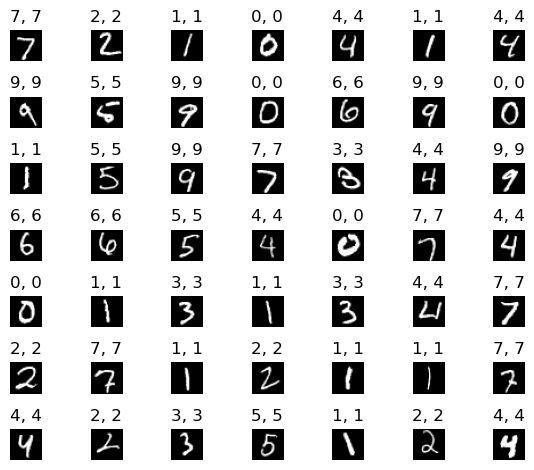

In [45]:
from matplotlib import pyplot as plt
it = iter(test_dataset)
rows = 7
cols = 7
# plt.figure()
for i in range(rows * cols):
    image, y_true = next(it)
    image = torch.unsqueeze(image, dim=0)
    image = image.to(device)
    unet.eval()
    output = unet(image)
    _, predicted = torch.max(output, 1)
    y_pred = predicted.item()
    plt.subplot(rows, cols, i+1)
    img = image.detach().squeeze(0).cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    if y_true == y_pred:
        plt.title(f"{y_true}, {y_pred}")
    else:
        plt.title(f"{y_true}, {y_pred}", color='red')
    plt.axis('off')
    plt.tight_layout()
plt.show()

In [44]:
import torch.nn as nn
up = nn.Upsample(scale_factor=2)
for images, targets in test_loader:
    up_x = up(images)
    print(images.shape, up_x.shape)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64, 1, 56, 56])


非常好的问题 👍
`nn.AdaptiveAvgPool2d(1)` 是一个在卷积网络中**非常常见的层**，
它的作用是 ——
👉 **无论输入的高宽是多少，都输出一个固定大小的特征图**（这里是 `1×1`）。

---

## 🧩 一句话解释

> `AdaptiveAvgPool2d(1)` 会对每个通道独立地取 **全局平均值**，
> 最后输出形状是 `[B, C, 1, 1]`。

这其实就是 **Global Average Pooling（GAP）** 的实现。

---

## 🧠 举个例子

假设输入：

```python
x.shape = [B, C, H, W] = [4, 32, 28, 28]
```

然后执行：

```python
pool = nn.AdaptiveAvgPool2d(1)
y = pool(x)
```

输出：

```
y.shape = [4, 32, 1, 1]
```

计算方式：
每个通道 `c` 的输出就是：
[
y_{b,c,0,0} = \frac{1}{H \times W} \sum_{i=1}^{H} \sum_{j=1}^{W} x_{b,c,i,j}
]

也就是说，对每个通道取平均值，保留“全局语义特征”，去掉空间信息。

---

## 🧮 举个小例子（数值）

```python
import torch
import torch.nn as nn

x = torch.tensor([
    [[[1., 2.],
      [3., 4.]]]
])  # shape [1, 1, 2, 2]

pool = nn.AdaptiveAvgPool2d(1)
y = pool(x)
print(y)
```

输出：

```
tensor([[[[2.5]]]])
```

因为 `(1+2+3+4)/4 = 2.5`。

---

## 🎯 应用场景

| 场景                           | 说明                                       |
| ---------------------------- | ---------------------------------------- |
| ✅ **分类任务**                   | 取整个特征图的平均作为全局特征，再接 `nn.Linear` 分类。       |
| 🧱 **ResNet / EfficientNet** | 都在最后一层卷积后使用 GAP 代替 Flatten。              |
| 🔄 **对不固定尺寸输入**              | 不管输入图像多大，最后都能变成 `[B, C, 1, 1]`，方便全连接层输入。 |

---

## 🔄 与 AvgPool2d 的区别

| 项目   | `AvgPool2d`    | `AdaptiveAvgPool2d` |
| ---- | -------------- | ------------------- |
| 池化窗口 | 固定大小（如 2×2）    | 自动计算（根据目标输出）        |
| 输出大小 | 由输入和 kernel 决定 | 由参数指定（例如 1×1）       |
| 典型用途 | 局部降采样          | 全局特征提取              |

---

## 🧩 在分类网络中的典型结构

```python
x = conv_features  # [B, C, H, W]
x = nn.AdaptiveAvgPool2d(1)(x)  # [B, C, 1, 1]
x = x.view(B, C)                 # [B, C]
x = nn.Linear(C, num_classes)(x) # [B, num_classes]
```

---

是否希望我帮你画一个小图（卷积特征图 → GAP → FC 分类的流程图）？这能更直观地看到为什么它能把整张图“压成一个向量”。


In [63]:
import torch.nn.functional as F
targets = torch.tensor([
    1, 3, 4, 8, 2, 6, 9, 0
])
targets = F.one_hot(targets, 10)
print(targets)

tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


In [60]:
test_dataset.targets[0: 8]

tensor([7, 2, 1, 0, 4, 1, 4, 9])

In [64]:
print(F.one_hot(test_dataset.targets, 10))

tensor([[0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


In [65]:
unet

OptimizedModule(
  (_orig_mod): Unet(
    (first_block_down): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GELU(approximate='none')
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (second_block_down): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GELU(approximate='none')
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (latent_space_block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GELU(approximate='none')
    )
    (second_block_up): Sequential(
      (0): Upsample(scale_factor=2.0, mode='nearest')
      (1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): GELU(approximate='none')
    )
    (first_block_up): Sequential(
      (0): Upsample(scale_factor=2.0, mode='nearest')
      (1): Conv2d(64, 32,

In [66]:
unet.parameters()

<generator object Module.parameters at 0x33de59310>

In [70]:
for param in unet.parameters():
    print(param.size(), type(param), str(list(param.size())))

torch.Size([32, 1, 3, 3]) <class 'torch.nn.parameter.Parameter'> [32, 1, 3, 3]
torch.Size([32]) <class 'torch.nn.parameter.Parameter'> [32]
torch.Size([64, 32, 3, 3]) <class 'torch.nn.parameter.Parameter'> [64, 32, 3, 3]
torch.Size([64]) <class 'torch.nn.parameter.Parameter'> [64]
torch.Size([128, 64, 3, 3]) <class 'torch.nn.parameter.Parameter'> [128, 64, 3, 3]
torch.Size([128]) <class 'torch.nn.parameter.Parameter'> [128]
torch.Size([64, 128, 3, 3]) <class 'torch.nn.parameter.Parameter'> [64, 128, 3, 3]
torch.Size([64]) <class 'torch.nn.parameter.Parameter'> [64]
torch.Size([32, 64, 3, 3]) <class 'torch.nn.parameter.Parameter'> [32, 64, 3, 3]
torch.Size([32]) <class 'torch.nn.parameter.Parameter'> [32]
torch.Size([10, 32]) <class 'torch.nn.parameter.Parameter'> [10, 32]
torch.Size([10]) <class 'torch.nn.parameter.Parameter'> [10]


In [71]:

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
for i in range(100):
    writer.add_scalar("y=x", i, i)
writer.close()
